### Будем распознавать заглавные латинские буквы  по заданному набору характеристик их изображений, используя три  классификатора :   XGBClassifier, LGBMClassifier и CatBoostClassifier.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
%matplotlib inline

## Предобработка

In [2]:
data = pd.read_csv("letter-recognition.data", header = None, 
    names = ['lettr','x-box','y-box', 'width', 'high','onpix','x-bar','y-bar','x2bar','y2bar','xybar','x2ybr',
             'xy2br','x-ege','xegvy','y-ege','yegvx'])

In [3]:
data.shape

(20000, 17)

In [4]:
data.dtypes

lettr    object
x-box     int64
y-box     int64
width     int64
high      int64
onpix     int64
x-bar     int64
y-bar     int64
x2bar     int64
y2bar     int64
xybar     int64
x2ybr     int64
xy2br     int64
x-ege     int64
xegvy     int64
y-ege     int64
yegvx     int64
dtype: object

In [5]:
data.isnull().sum()

lettr    0
x-box    0
y-box    0
width    0
high     0
onpix    0
x-bar    0
y-bar    0
x2bar    0
y2bar    0
xybar    0
x2ybr    0
xy2br    0
x-ege    0
xegvy    0
y-ege    0
yegvx    0
dtype: int64

In [6]:
data.describe()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,4.023550,7.035500,5.121850,5.37245,3.505850,6.897600,7.500450,4.628600,5.178650,8.282050,6.45400,7.929000,3.046100,8.338850,3.691750,7.80120
std,1.913212,3.304555,2.014573,2.26139,2.190458,2.026035,2.325354,2.699968,2.380823,2.488475,2.63107,2.080619,2.332541,1.546722,2.567073,1.61747
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.000000,5.000000,4.000000,4.00000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.00000,7.000000,1.000000,8.000000,2.000000,7.00000
50%,4.000000,7.000000,5.000000,6.00000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.00000,8.000000,3.000000,8.000000,3.000000,8.00000
75%,5.000000,9.000000,6.000000,7.00000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.00000,9.000000,4.000000,9.000000,5.000000,9.00000
max,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.00000


In [7]:
X = data.drop(['lettr'], axis = 1)
le = LabelEncoder()
y = le.fit_transform(data['lettr'])

## ML

In [9]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3,
            stratify = y, random_state = 42)

In [10]:
def GridSearch(est, params, XTrain, yTrain):
    cv = StratifiedKFold(
        n_splits = 5,
        shuffle = True,
        random_state = 42)
    grid = GridSearchCV(
        estimator = est,
        param_grid = params,
        cv = cv.split(XTrain, yTrain),
        n_jobs = -1,
        verbose = 3)
    grid.fit(XTrain, yTrain)
    return grid.best_estimator_

### XGBClassifier

In [11]:
xgbc = XGBClassifier(
    objective = 'multi:softprob',
    booster = 'gbtree',
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42
 )

In [14]:
xbgParams = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [6, 7, 8],
    'num_boosting_rounds': [100, 200, 300],
    'eval_metric': ['merror', 'mlogloss']
}

In [15]:
bestXGB = GridSearch(xgbc, xbgParams, XTrain, yTrain)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 42.9min finished


In [22]:
def Report(bestCls, X, yTest):
    yPred = bestCls.predict(XTest)
    yPred0 = le.inverse_transform(yPred)
    yTest0 = le.inverse_transform(yTest)
    print(classification_report(yTest0, yPred0))
    return pd.DataFrame(bestCls.feature_importances_,X.columns).plot(
        kind='barh', legend= False, title = 'Важность признаков')

              precision    recall  f1-score   support

           A       0.99      0.98      0.99       237
           B       0.90      0.97      0.93       230
           C       0.96      0.95      0.95       221
           D       0.94      0.96      0.95       242
           E       0.95      0.96      0.96       230
           F       0.94      0.95      0.95       232
           G       0.96      0.94      0.95       232
           H       0.92      0.95      0.93       220
           I       0.97      0.93      0.95       226
           J       0.96      0.95      0.96       224
           K       0.94      0.93      0.94       222
           L       0.98      0.97      0.97       228
           M       0.96      0.97      0.97       238
           N       0.97      0.92      0.95       235
           O       0.97      0.96      0.97       226
           P       0.97      0.98      0.97       241
           Q       0.97      0.97      0.97       235
           R       0.94    

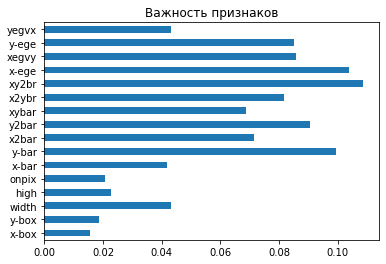

In [24]:
df = Report(bestXGB, X, yTest)

### LGBMClassifier

In [25]:
lgbmc = LGBMClassifier(
    silent=False,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42)

In [27]:
lgbmParams = {
    'learning_rate' : [0.1, 0.2, 0.3],
    'max_depth': [6, 7, 8],
    'n_estimators': [100, 200, 300],
    'metric': ['multi_error', 'multi_logloss']
}

In [28]:
bestLGBM = GridSearch(lgbmc, lgbmParams, XTrain, yTrain)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 27.3min finished


              precision    recall  f1-score   support

           A       1.00      1.00      1.00       237
           B       0.91      0.98      0.95       230
           C       0.97      0.96      0.97       221
           D       0.96      0.98      0.97       242
           E       0.96      0.98      0.97       230
           F       0.96      0.94      0.95       232
           G       0.97      0.95      0.96       232
           H       0.94      0.95      0.95       220
           I       0.96      0.95      0.95       226
           J       0.96      0.95      0.95       224
           K       0.97      0.96      0.97       222
           L       0.98      0.99      0.98       228
           M       0.99      0.99      0.99       238
           N       0.99      0.95      0.97       235
           O       0.97      0.96      0.97       226
           P       0.96      0.98      0.97       241
           Q       0.97      0.97      0.97       235
           R       0.95    

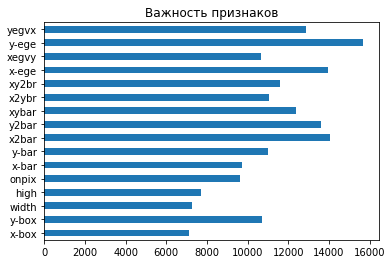

In [29]:
df = Report(bestLGBM, X, yTest)

### CatBoostClassifier

In [41]:
cbc = CatBoostClassifier(
    bootstrap_type = 'MVS',
    subsample = 0.8,
    random_state = 42
)

In [44]:
cbParams = {
        'learning_rate' :  [0.1, 0.2, 0.3],
        'depth': [6, 7, 8],
        'n_estimators': [100, 200, 300]
}

In [45]:
bestCB = GridSearch(cbc, cbParams, XTrain, yTrain)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.3min
/home/alex/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 31.7min finished


0:	learn: 2.0892601	total: 146ms	remaining: 43.7s
1:	learn: 1.6618497	total: 234ms	remaining: 34.9s
2:	learn: 1.3830364	total: 325ms	remaining: 32.2s
3:	learn: 1.2061822	total: 439ms	remaining: 32.5s
4:	learn: 1.0668825	total: 526ms	remaining: 31s
5:	learn: 0.9727365	total: 610ms	remaining: 29.9s
6:	learn: 0.8831297	total: 715ms	remaining: 29.9s
7:	learn: 0.8057727	total: 805ms	remaining: 29.4s
8:	learn: 0.7376801	total: 890ms	remaining: 28.8s
9:	learn: 0.6987087	total: 996ms	remaining: 28.9s
10:	learn: 0.6496510	total: 1.08s	remaining: 28.4s
11:	learn: 0.6041073	total: 1.17s	remaining: 28.1s
12:	learn: 0.5775281	total: 1.27s	remaining: 28.1s
13:	learn: 0.5457212	total: 1.36s	remaining: 27.8s
14:	learn: 0.5172850	total: 1.45s	remaining: 27.5s
15:	learn: 0.4935435	total: 1.55s	remaining: 27.6s
16:	learn: 0.4717922	total: 1.64s	remaining: 27.3s
17:	learn: 0.4538532	total: 1.73s	remaining: 27.1s
18:	learn: 0.4361665	total: 1.83s	remaining: 27.1s
19:	learn: 0.4209702	total: 1.93s	remaining

162:	learn: 0.0461285	total: 16.4s	remaining: 13.8s
163:	learn: 0.0458238	total: 16.5s	remaining: 13.7s
164:	learn: 0.0455626	total: 16.6s	remaining: 13.6s
165:	learn: 0.0453204	total: 16.7s	remaining: 13.5s
166:	learn: 0.0451617	total: 16.7s	remaining: 13.3s
167:	learn: 0.0448244	total: 16.8s	remaining: 13.2s
168:	learn: 0.0445057	total: 16.9s	remaining: 13.1s
169:	learn: 0.0441578	total: 17s	remaining: 13s
170:	learn: 0.0437023	total: 17.1s	remaining: 12.9s
171:	learn: 0.0433122	total: 17.2s	remaining: 12.8s
172:	learn: 0.0430027	total: 17.3s	remaining: 12.7s
173:	learn: 0.0425759	total: 17.4s	remaining: 12.6s
174:	learn: 0.0421157	total: 17.5s	remaining: 12.5s
175:	learn: 0.0417771	total: 17.6s	remaining: 12.4s
176:	learn: 0.0413565	total: 17.7s	remaining: 12.3s
177:	learn: 0.0410916	total: 17.8s	remaining: 12.2s
178:	learn: 0.0406936	total: 17.8s	remaining: 12.1s
179:	learn: 0.0404686	total: 17.9s	remaining: 11.9s
180:	learn: 0.0403742	total: 18s	remaining: 11.8s
181:	learn: 0.0399

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           A       0.99      0.99      0.99       237
           B       0.90      0.97      0.94       230
           C       0.98      0.95      0.96       221
           D       0.94      0.96      0.95       242
           E       0.96      0.95      0.96       230
           F       0.96      0.95      0.95       232
           G       0.97      0.97      0.97       232
           H       0.92      0.95      0.93       220
           I       0.97      0.92      0.94       226
           J       0.95      0.96      0.95       224
           K       0.95      0.93      0.94       222
           L       0.99      0.97      0.98       228
           M       0.99      0.98      0.99       238
           N       0.96      0.95      0.96       235
           O       0.96      0.95      0.96       226
           P       0.97      0.98      0.98       241
           Q       0.97      0.97      0.97       235
           R       0.94    

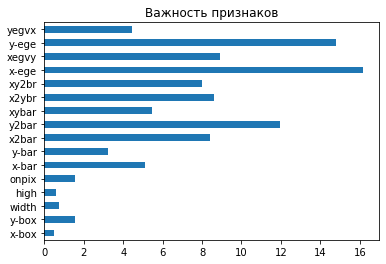

In [47]:
df = Report(bestCB, X, yTest)

### Классификаторы дали одинаковые средние метрики качества обучения. При этом, их функции распределения важности признаков существенно различаются.  LGBMClassifier потратил на работу почти в два раза меньше времени, чем XGBClassifier или CatBoostClassifier (время работы последнего надо умножить на два, так как он получил вдвое меньше вариантов набора параметров).